In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from numpy import absolute
from numpy import mean
from numpy import std

# input data into DataFrame from previous work

In [3]:
df = pd.read_csv ('/Users/archana/Desktop/MEtis/Regression/regression_project/movie_df_2.csv')

# Feature Transformation and Enginieering

In [4]:
df['genres_list'] = df['genres'].apply(lambda x: (x.split(',')))

#Changing release_date field's data type to datetime
df['release_date']= pd.to_datetime(df['release_date'])

#creating dummies for genres- genres up to 5 in one category and above 5 in another.
df['genres_upto5'] = (df['genres_num']<=5).astype(int)

#df = df.drop('genres_num',axis = 1)
#df = df.drop('genres',axis = 1)

# 10 movies rated G are imputed as PG
df['mpaa'].mask(df['mpaa'] == 'G', 'PG', inplace=True)

#Creating dummies for 'mpaa' feature
mpaa_dummies = pd.get_dummies(df['mpaa'],drop_first=True)
# Drop column as it is now encoded
df = df.drop('mpaa',axis = 1)
# Join the encoded df
df = df.join(mpaa_dummies)

dist_count = df['dist_name'].value_counts()
other_dist = list(dist_count[dist_count<100].index)
df['dist_name'] = df['dist_name'].replace(other_dist, 'other')


#creating dummies for Distributer feature. Taking top two distributers and categorizing all others in 'Others'
dist_dummies = pd.get_dummies(df['dist_name'],drop_first=True)
# Drop column as it is now encoded
df = df.drop('dist_name',axis = 1)
# Join the encoded df
df = df.join(dist_dummies)

# is_weekend flag 
# changing date feature to show if it is weekend release or weekday release
day_names = df.release_date.dt.day_name()
df['is_weekend_release'] = day_names.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)


df = df.drop('release_date',axis = 1)

# View the correlations
df.shape

(1336, 17)

In [6]:
df.head()

,title,opening,running_time,genres,in_release_days,percentage_dom,gross_dom,num_theaters,genres_num,genres_list,genres_upto5,PG,PG-13,R,Warner Bros.,other,is_weekend_release
0,Jurassic World,208806270.0,124.0,"Action,Adventure,Sci-Fi",210.0,39.0,652270625,4291.0,3,"[Action, Adventure, Sci-Fi]",1,0,1,0,0,0,0
1,Star Wars: Episode VII - The Force Awakens,247966675.0,138.0,"Action,Adventure,Sci-Fi",380.0,45.3,936662225,4134.0,3,"[Action, Adventure, Sci-Fi]",1,0,1,0,0,1,0
2,Avengers: Age of Ultron,191271109.0,141.0,"Action,Adventure,Sci-Fi",245.0,32.7,459005868,4276.0,3,"[Action, Adventure, Sci-Fi]",1,0,1,0,0,1,0
3,Inside Out,90440272.0,95.0,"Adventure,Animation,Comedy,Drama,Family,Fantasy",203.0,41.6,356461711,4158.0,6,"[Adventure, Animation, Comedy, Drama, Family, ...",0,1,0,0,0,1,0
4,Furious 7,147187040.0,137.0,"Action,Crime,Thriller",273.0,23.3,353007020,4022.0,3,"[Action, Crime, Thriller]",1,0,1,0,0,0,0


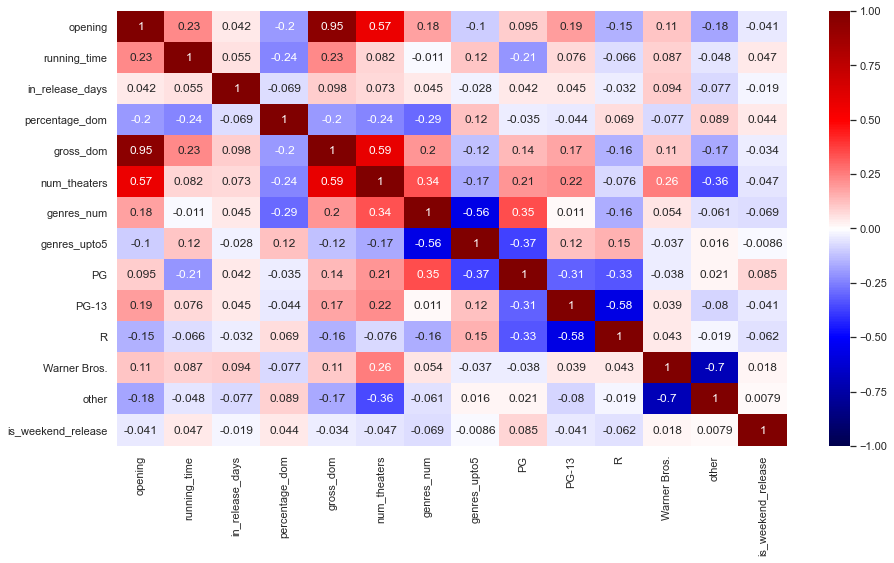

In [7]:
#corr matrix and heatmap
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# Running Time - Duration of movie EDA

<ipython-input-74-a0612749405e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runtime['duration'] = df_runtime['running_time'].apply(duration_of_movie)


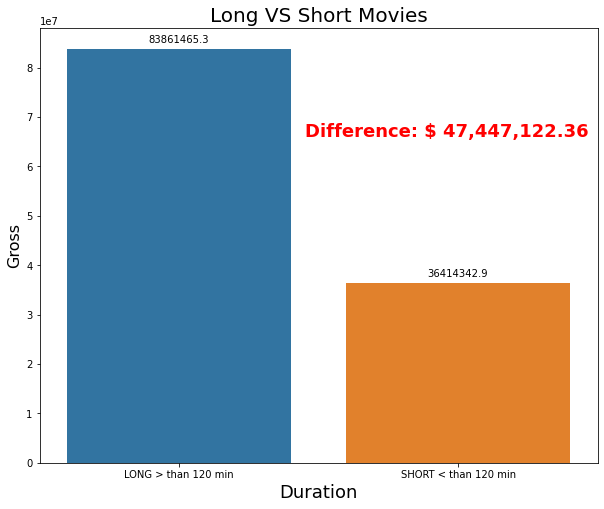

47447122.36

In [74]:
from matplotlib import rcParams

df_runtime = df[['title','running_time','gross_dom']]
def duration_of_movie(x):
    if x < 120:
        return 'SHORT < than 120 min'
    if x > 120:
        return 'LONG > than 120 min'
df_runtime['duration'] = df_runtime['running_time'].apply(duration_of_movie)
groupedvalues = df_runtime.groupby('duration').mean().reset_index()
ax = sns.barplot(x='duration', y='gross_dom',
                  data=groupedvalues,
                  errwidth=0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
plt.title('Long VS Short Movies', fontdict={'fontsize':20})
plt.xlabel('Duration', fontsize=18)
plt.ylabel('Gross', fontsize=16)
plt.text(0.45, 66000000, 'Difference: $ 47,447,122.36',{'color':'red','weight':'heavy','size':18})
plt.show()


difference = groupedvalues.iloc[0, 2]-groupedvalues.iloc[1, 2]
round(difference,2)


# Genre correlation

In [12]:
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

x = df['genres_list']
te = TransactionEncoder()
x = te.fit_transform(x)
x = pd.DataFrame(x, columns = te.columns_)
x.head()
gen = x.astype('int')
gen.insert(0,'movie_title',df['title'])
gen = gen.set_index('movie_title')


df3 = gen.corr()
df3.insert(0,'g1',df3.index)
df3.reset_index(drop=True, inplace=True)
df_unpivoted = df3.melt(id_vars=['g1'], var_name='g2', value_name='corr')
df_unpivoted.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
df_unpivoted

df_unpivoted['rank'] = df_unpivoted.groupby('g1')['corr'].rank(ascending=False)
df_unpivoted.sort_values(by = ['g1','rank'],inplace=True)
df7 = df_unpivoted[df_unpivoted['rank'].isin([2,23])]# == 2 OR df_unpivoted['rank'] == 1]

df_unpivoted.head(50)
df7
df7.to_csv(r'/Users/archana/Desktop/MEtis/Regression/regression_project/genre_corr_high_low.csv', index = None, header=True)




# Features Correlation with Gross

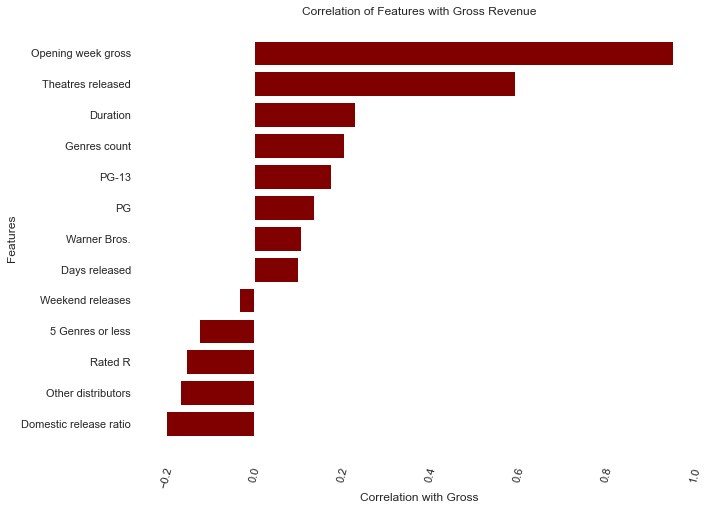

In [13]:
import matplotlib.pyplot as plt

#cdf = pd.DataFrame(df[df.columns[1:]].corr()['gross_dom'][:])
ser = df.corrwith(df["gross_dom"])
cdf = pd.DataFrame({'features':ser.index, 'correlation':ser.values})
#cdf = cdf.loc[df["features"] =='gross_dom' ]
cdf.drop(cdf.loc[cdf['correlation']==1].index, inplace=True)
cdf.sort_values(by = 'correlation', inplace=True,ascending = True)


cdf['features'] = cdf['features'].replace(
    ['percentage_dom','other','R','genres_upto5','is_weekend_release',
    'in_release_days','genres_num','running_time','num_theaters','opening'],
    ['Domestic release ratio','Other distributors','Rated R','5 Genres or less','Weekend releases',
    'Days released','Genres count','Duration','Theatres released','Opening week gross'])

fig = plt.figure(figsize = (10, 8))


plt.rcParams['axes.facecolor'] = 'white'
plt.barh(cdf['features'], cdf['correlation'], color ='maroon')
plt.xlabel("Correlation with Gross")
plt.xticks(rotation=75)
plt.ylabel("Features")
plt.title("Correlation of Features with Gross Revenue")
plt.show()


# Pair Plots

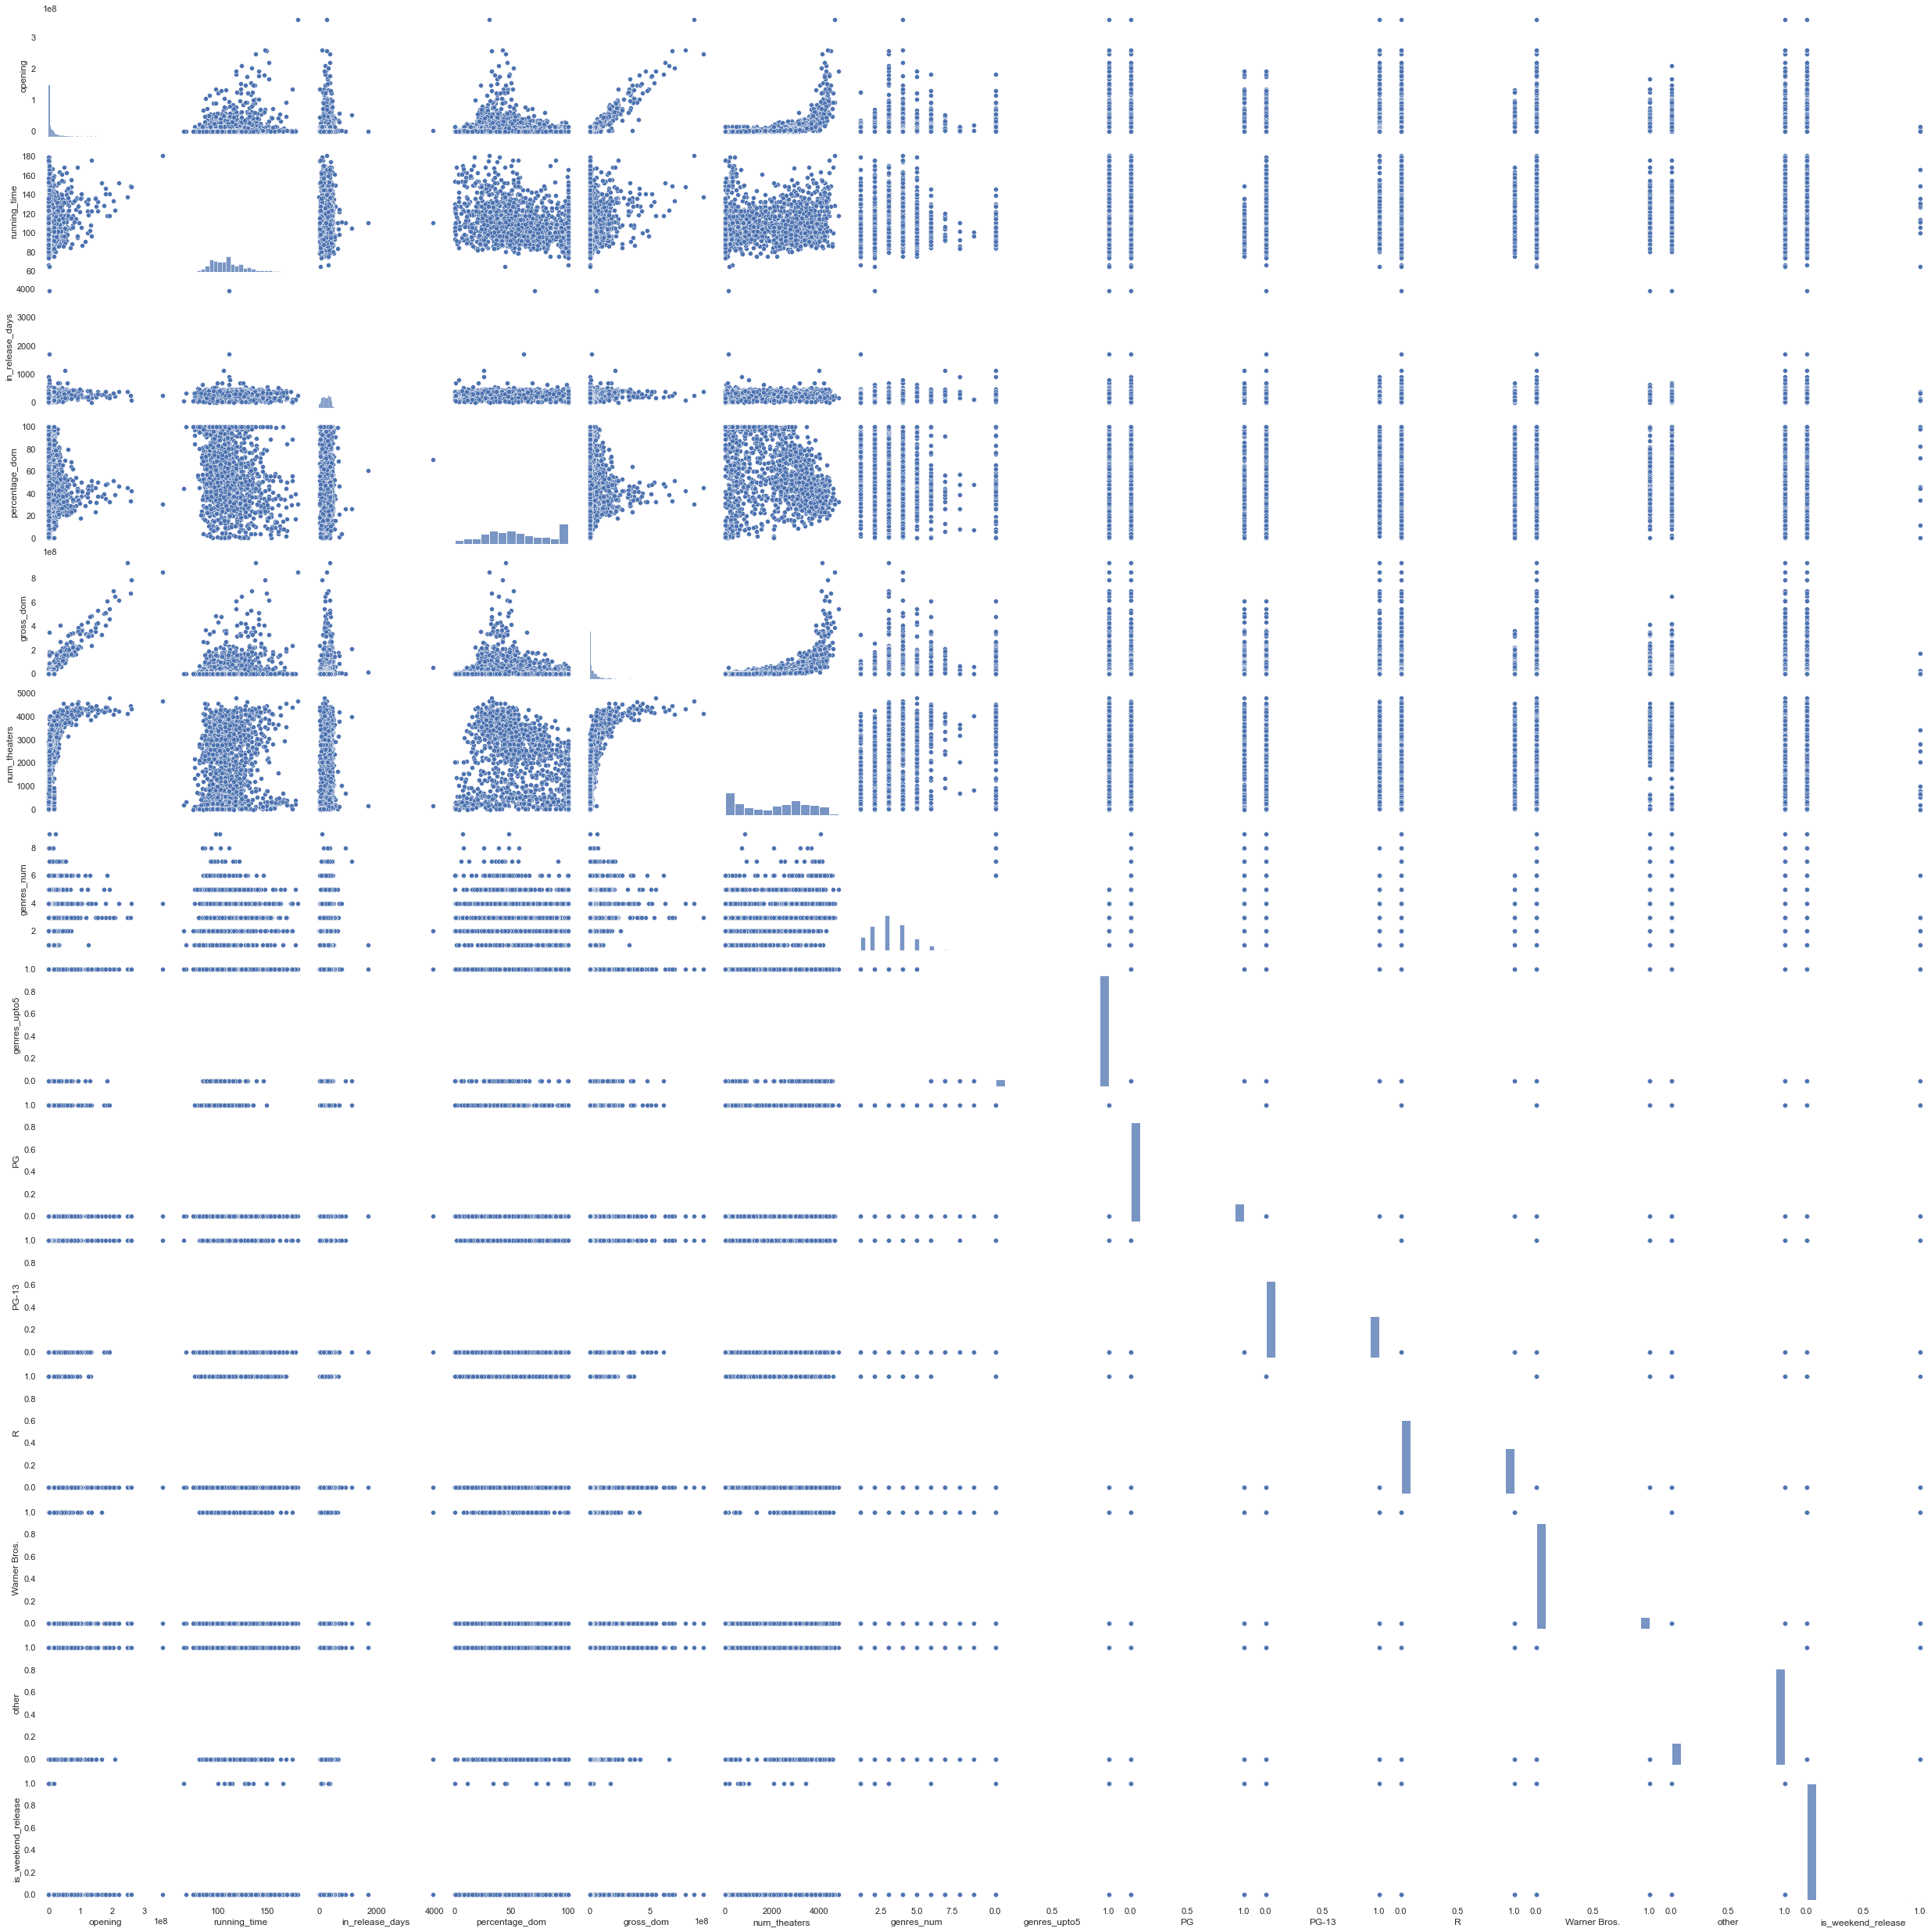

In [14]:
sns.pairplot(df)

# Split Data into Train-Validation-Test

In [16]:
from sklearn.model_selection import train_test_split

#X = df.drop(columns=['gross_dom','title','genres_upto5','PG','PG-13','is_weekend_release','genres_num'])#.93 and .93
X = df.drop(columns=['gross_dom','title','genres_list',
                     'genres','opening'])
y = df['gross_dom']

X, X_test, y, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=43)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                       test_size=.25,     
                                       random_state=43)

# linear regression on train data

0.4147990221233715
0.34363439843295895
44700035.45


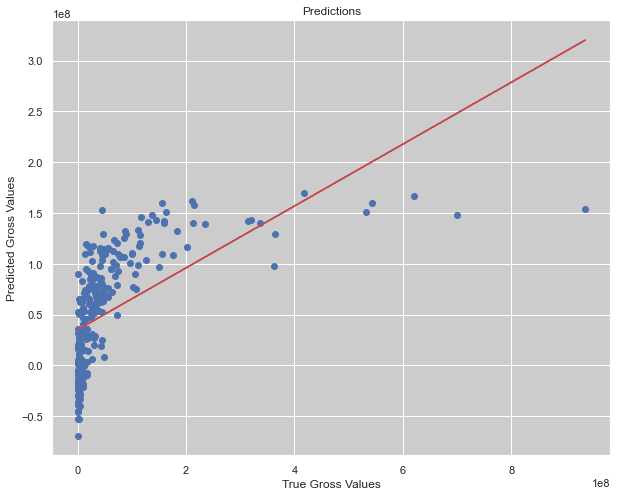

In [20]:
from sklearn.linear_model import LinearRegression 
from matplotlib import pyplot as plt
from sklearn import metrics
from numpy.polynomial.polynomial import polyfit

model = LinearRegression()
lr = model.fit(X_train,y_train)

r_squared_train = lr.score(X_train, y_train)
r_squared_val = lr.score(X_val, y_val)

#Calculating MAE as a metric
# predictions = lr.predict(X_train)
# plt.scatter(y_train, predictions)
# plt.xlabel('True Y Values')
# plt.ylabel('Predicted Y Values')
# MAE_train = round(metrics.mean_absolute_error(y_train, predictions),2)

plt.rcParams['axes.facecolor'] = '0.8'
plt.rcParams["figure.figsize"] = (10,8)
predictions_val = lr.predict(X_val)
plt.scatter(y_val, predictions_val)
plt.title('Predictions')
plt.xlabel('True Gross Values')
plt.ylabel('Predicted Gross Values')
MAE_val = round(metrics.mean_absolute_error(y_val, predictions_val),2)

b, m = polyfit(y_val, predictions_val, 1)
plt.plot(y_val, b + m * y_val, '-',color='r')

print(r_squared_train)
print(r_squared_val)
#print(MAE_train)
print(MAE_val)


## Findings - Linear Regression - r_squared values 
1.In this case the model is overfitting as the R2 value of training data is greater than validation data.

## Polynomial transformation of X_train values


0.6412289074426542
0.54022477155438
36347707.01


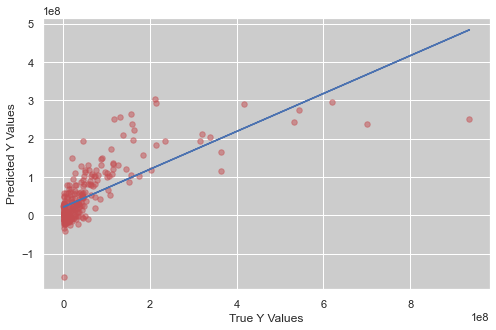

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.polynomial import polyfit


# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.fit_transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
r_squared_train_poly = lr_poly.score(X_train_poly, y_train)
r_squared_val_poly = lr_poly.score(X_val_poly, y_val)

#Calculating MAE as a metric
# predictions = lr_poly.predict(X_train_poly)
# plt.scatter(y_train, predictions)
# plt.xlabel('True Y Values')
# plt.ylabel('Predicted Y Values')
# MAE_train_poly = round(metrics.mean_absolute_error(y_train, predictions),2)

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['axes.facecolor'] = '0.8'
predictions_val = lr_poly.predict(X_val_poly)
plt.scatter(y_val, predictions_val,s=30, color='r', marker='o',alpha=.5)
plt.xlabel('True Y Values')
plt.ylabel('Predicted Y Values')
MAE_val_poly = round(metrics.mean_absolute_error(y_val, predictions_val),2)

b, m = polyfit(y_val, predictions_val, 1)
plt.plot(y_val, b + m * y_val, '-')


print(r_squared_train_poly)
print(r_squared_val_poly)
#print(MAE_train_poly)
print(MAE_val_poly)

# Better R squared value. Applying this on test data

0.7332664933144042
24925058.63


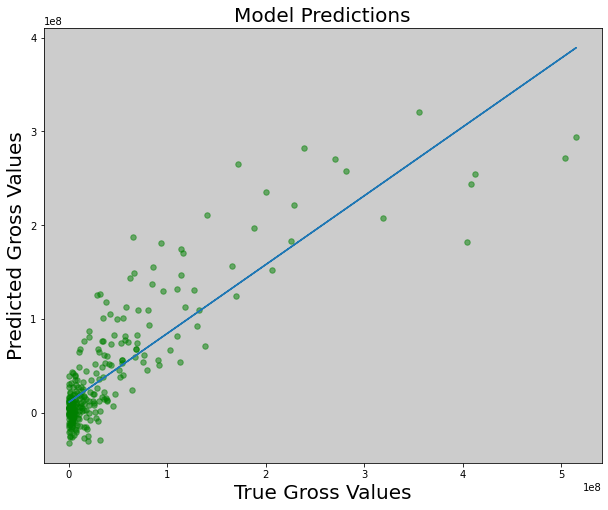

In [129]:
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.polynomial import polyfit


# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_test_poly = poly.fit_transform(X_test)

# Apply polynomial transformation to val set
#X_val_poly = poly.fit_transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_test_poly,y_test)
r_squared_test_poly = lr_poly.score(X_test_poly, y_test)
#r_squared_val_poly = lr_poly.score(X_val_poly, y_val)

#Calculating MAE as a metric
# predictions = lr_poly.predict(X_train_poly)
# plt.scatter(y_train, predictions)
# plt.xlabel('True Y Values')
# plt.ylabel('Predicted Y Values')
# MAE_train_poly = round(metrics.mean_absolute_error(y_train, predictions),2)
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['axes.facecolor'] = '0.8'
#plt.set_facecolor('black')
predictions_test = lr_poly.predict(X_test_poly)
plt.scatter(y_test, predictions_test,s=30, color='g', marker='o',alpha=.5)
plt.title('Model Predictions',size = 20)
plt.xlabel('True Gross Values',size=20)
plt.ylabel('Predicted Gross Values',size=20)
MAE_test_poly = round(metrics.mean_absolute_error(y_test, predictions_test),2)

b, m = polyfit(y_test, predictions_test, 1)
plt.plot(y_test, b + m * y_test, '-')

print(r_squared_test_poly)

print(MAE_test_poly)


R squared value of 0.73 is a huge improvement from 0.41 in train data and 0.64 in validation data

# Plotting Residuals

In [42]:
residual = (y_test - predictions_test)

<AxesSubplot:xlabel='gross_dom'>

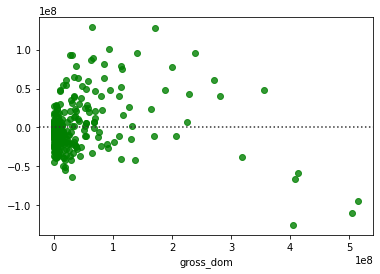

In [43]:
# Plot the residuals after fitting a linear model
sns.residplot(x=y_test, y=predictions_test,  color="g")
